## Алгоритм Метрополиса-Гастингcа ##

In [448]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from sklearn import datasets
from scipy.stats import norm
from itertools import product
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.collections import LineCollection

## Введение. О чём мы? ##

Есть два распределения:

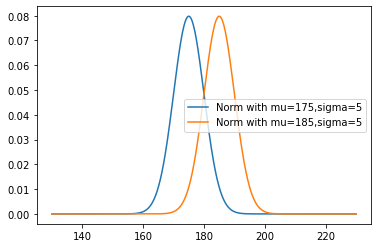

In [2]:
x = np.linspace(130,230,5000)
y1 = norm(175,5).pdf(x) 
y2 = norm(185,5).pdf(x)
plt.plot(x, norm.pdf(x,175,5), label='Norm with mu=175,sigma=5')
plt.plot(x, norm.pdf(x,185,5), label='Norm with mu=185,sigma=5')
plt.legend()

Мы хотим получить их произведение:

$$ p(y) = p_{1}(y)p_{2}(y) $$

Мы знаем плотность вероятности обоих распределений в каждой точке, поэтому нам нужно перемножить плотности в каждой точке.<br>

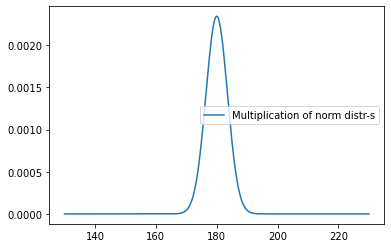

In [3]:
plt.plot(x, norm.pdf(x,175,5) *  norm.pdf(x,185,5), label='Multiplication of norm distr-s' )
plt.legend()

Но ведь $p_{1}(y)$ и $p_{2}(y)$ заданы параметрами — матожиданием и дисперсией, а для их произведения придётся считать вероятность в каждой точке? Что-то не очень....
<br><br>
**Определение:** <br><br>
**<em>Сопряжённое априорное распределение (Conjugate prior) </em>**- произведение многих известных распределений даёт другое известное распределение с легко вычислимыми параметрами
<br><br>

Чтобы понять, что к чему немного подробнее о статистике,посмотрим чем Баесовская статистика отличается от частотной:<br>
<br>
* $P_{\theta}(Y)$ - определение случайной переменной Y, которая зависит от парметра $\theta$ в частотной статистике
<br><br>
* $P(Y|\theta)$ - определение случайной переменной Y, которая зависит от парметра $\theta$ в Баесовской статистике
<br><br>
В Баесовской статистике выносят параметры распределения в отдельную случайную переменную с собственным распределением, т.е. в байесовском подходе мы уже работаем не с одной случайной переменной Y, а с двумя, причём связанными:

 $$\theta \rightarrow Y$$ 
 
Поскольку $\theta$ ни от чего не зависит, то для него достаточно определить $P(\theta)$, а вот $Y$ зависит от $\theta$, так что для него понадобится условное распределение — $P(Y|\theta)$ <br><br>
Вообще, эти два распределения никак не связаны и представляют собой 2 абсолютно независимые функции.<br>
Однако, если мы ничего не знаем о системе, то и сделать с ней ничего не можем, по этому упрощаем:
* Cчитаем, что $P(\theta)$ и $P(Y|\theta)$ принадлежат к какому-нибудь красивому и хорошо изученному распределению
<br><br>
* По возможности стараемся сделать $P(\theta)$ и $P(Y|\theta)$ сопряжёнными (чтобы по красивым формулам априорного распределение высчитать параметры апостериорного)

**Определение**:<br><br>
Если апостериорное распределение $p(\theta |x)$ принадлежит тому же семейству вероятностных распределений, что и априорное распределение $p(\theta )$ (т.е. имеет тот же вид, но с другими параметрами), то это семейство распределений называется **<em>сопряжённым семейству функций правдоподобия<em>** $p(x|\theta )$.
![title](img/1.png)

## Вопрос 1. А нафига эта информация? ##



Один из основных инструментов машинного обеспечения - теорема Баеса, все мы ее прекрасно знаем:

$$ p(Y| \theta)  = \frac{p(Y)p(\theta|Y)}{p(\theta)}$$ 
Где:
* $ p(Y) $ - <em>априорное распределение</em> - то, что мы думаем о $\theta$ до проведения экспериментов, до получения данных
<br><br>
* $p(\theta|Y) $ - <em>функция правдоподобия</em> - вероятность увидеть данные $\theta$ при таком значении выходного парметра $Y$<br><br>
* $ p(\theta) = \int p(Y,\theta) d\theta $ - <em>маргинальное правдоподобие</em> - вероятность вообще увидеть такой объект (Оно одинаково для всех $\theta$ , так что его чаще всего не считают, а просто максимизируют числитель формулы Байеса)<br><br>
* $ p( Y| \theta) $ - <em> апостериорное распределение</em> - распределение вероятностей, вычисленная после того, как приняты во внимание данные $ \theta $ <br><br>

К чему обычно сводится задача, Баесовского вывода?<br><br>
В общем, это не загадка - найти апостериорное распределение на гипотезах/параметрах:

$$p(Y|\theta) \propto  p(\theta|Y)p(Y)$$

а затем найти максимальную апостериорную гипотезу:

$$ arg max_{\theta} p(Y|\theta) $$

И собственно, хотим научиться пресказывать новую точку данных при словии имеющихся точек данных:

$$ \bar{Y_{n}} \sim p(Y|\theta) $$


$$ p( d | \theta) = \int p( d  | Y) p( Y | \theta ) dY $$
<br>

**Пробелeма:** Распределения, которые нас интересуют, обычно слишком сложные, чтобы их можно было высчитывать напрямую, аналитически ( слишком много переменных / между переменными слишком сложные связи).
<br><br>
Зато мы можем рассматривать $\int p( d  | Y) p( Y | \theta ) dY $ как:

$$ \mathbb{E}_{\bar{Y_{n}} \sim p(Y|\theta)}  [ p(d | \theta)] \approx \frac{1}{R} \sum_{r=1}^{R} p(d|\theta^{r})  $$

**Разберём на конкретном пример**:<br><br>
Мы хотим рассортировать по темам новостей на основе уже имеющейся базы данных с темами: спорт, экономика, культура и т.д. ( многие помнят этот датасет с Теории Информации).<br><br> 
Используем bag-of-words то есть новость теперь это множество слов, которые в нёй содержатся => В результате каждая новость $x$ принимает значения из множества категорий $V$ и описывается атрибутами:  $(a_{1},a_{2},...,a_{n})$

**Попытемся применить формулу Баеса на прямую:**<br><br>
Нам нужно найти наиболее вероятное значение данного атрибута, т.е.:

$$ \underset{v\in V}{arg max}(p(x=v|a_{1},a_{2},...,a_{n}))$$

По теореме Баеса получаем:<br>
$$\underset{v\in V}{arg max}\frac{p(a_{1},a_{2},...,a_{n}|x=v)p(x=v)}{p(a_{1},a_{2},...,a_{n})} =\underset{v\in V}{arg max}{(p(a_{1},a_{2},...,a_{n}|x=v)p(x=v)) }$$
Где:
* $p(x=v)$ - частоту встречаемости слова
* $p(a_{1},a_{2},...,a_{n}|x=v)$ - <em>вероятность в точности такого набора слов в сообщениях на разные темы<em> -**cложно да?**
<br><br>

Поэтому делается предположение об условной независимости слов при условии темы то есть разные слова в тексте на одну и ту же тему появляются независимо друг от друга:

$$p(a_{1},a_{2},...,a_{n}|x=v)=p(a_{1}|x=v)p(a_{2}|x=v)...p(a_{n}|x=v)$$
<br>
В результате сложное апостериорное распределение  $p(a_{1},a_{2},...,a_{n}|x=v)p(x=v)$ переписали:

$$ p(a_{1}|x=v)p(a_{2}|x=v)...p(a_{n}|x=v)p(x=v) $$

И дальше всё просто обучить параметры каждого маленького распределения по отдельности, а затем выбрать $v$, дающее максимум произведения
<br><br>

## Вопрос 2. Сэмплирование.  ##

## Алгоритм Метрополиса-Гастингcа <br>

**Что это вообще:** Алгоритм есть моделирование Цепи Маркова с некоторым стационарным распределением - МСМС.
<br><br>
**Основная фишка MCMC:** Если долго ходить по Марковской цепи, то точка которая в конечном итоге взята - взята по стационарному распределению $ p(x) $
<br><br>
**Основная идея:** Гуляем под сложным графиком распределения $ p(x) $ при помощи распределения перехода $ Q $ так долго, чтобы потом сказать, что наша очередная точка это семпл из $ p(x) $, причём мы организуем этот процесс так, чтобы наша $ p(x) $ оказалась стационарным распределением для марковской цепи, которая гуляет распределением перехода $ Q $ 

### Часть I. Ядро перехода (Sampler) ###


Чтобы реализовать алгоритм Метрополиса-Гастингса нам необходимо определить ядро перехода $Q$,мы его определяем САМИ.
<br> 
**Ядро перехода** - это просто способ случайного перемещения в новую позицию в пространстве (скажем, y), учитывая текущую позицию (скажем, x), то есть $Q$ - распределение по y для заданного x: 

$$Q =Q(y|x)$$

В своем большинсте, $Q$ - непрерывное распределение, то есть $Q(y|x)$ - плотность распределениея на y и поэтому $\forall x: \int Q(y|x)dy = 1$<br><br>
Проще всего получить следущую точку $y$ по текущей $x$ добавить к ней число выбранное по нормальному распределению $N(0,1)$:

$$y=x+ N(0,1) $$

Тогда получим, ядро "Случайного блуждания" (random walk) :
$$ Q(y|x) = \frac{1}{\sqrt{2\pi}}e^{-0.5*(y-x)^{2}} $$

### Часть II. Псевдокод Алгоритма ###


1. Берем совершенно случайным образом первую точку: $y$
2. Для $t=1,2,..$:
    * Выбираем место для перехода, то есть высчитываем $y$ из $Q(x|y)$
    * Оцениваем подходит ли выбранное место для перехода, оно должно "лучше объяснять данные" то есть высчитываем "вероятность принятия": $$ A = min(1,\frac{p(y)Q(x_{t}|y)}{p(x_{t})Q(y|x_{t})} )$$
    * С вероятностью $A$ мы принимаем предлженное место и устанавливаем $x_{t+1} = y$, иначе $x_{t+1}=x_{t}$

In [409]:
def sampler(likelihood_log_function,data, aprior_mean, aprior_sigma, samples, mu_init , q_sigma = 0.1 , burn_in = 0 ,plot=False):
    accepted = 0
    mu_current = mu_init
    posterior = [mu_current]
    np.random.seed(seed=100000)
    for i in range(1 ,samples + burn_in):
        # Выбираем место для перехода
        mu_proposal =  mu_current + np.random.normal(0, q_sigma)

        # высчитываем функцию правдоподобия в текущей и предложенной точке - Q
        likelihood_proposal = likelihood_log_function(mu_proposal)
        likelihood_current = likelihood_log_function(mu_current)
        
        # высчитываем вероятность текущей и предложенной точки      
        prior_proposal = norm.logpdf(mu_proposal,loc = aprior_mean ,scale = aprior_sigma)
        prior_current = norm.logpdf(mu_current,loc = aprior_mean ,scale = aprior_sigma)
                
        p_proposal =  likelihood_proposal + prior_proposal
        p_current = likelihood_current + prior_current
        
        # высчитваем вероятность принятия
        p_accept = p_proposal - p_current
        accept = np.exp(p_accept) > np.random.rand()
        
        if plot and i >= burn_in:
            plot_proposal(mu_current, mu_proposal, data , accept, posterior[burn_in-1:], i - burn_in , aprior_mean, aprior_sigma)
        
        if accept:
            if (i >= burn_in):
                accepted +=1
            mu_current = mu_proposal
        
        posterior.append(mu_current)
    if not plot:
        return {"posterior": np.array(posterior)[burn_in-1:], "acceptance percentage": 100 * accepted / samples}

In [685]:
def sampler(likelihood_log_function, samples, q_sigma = 0.1, x_init = np.array([0,0])):
    x_current = x_init
    posterior, is_accepted = [x_current],[1]
    np.random.seed(seed=100000)
    for i in range(samples):
        # Выбираем место для перехода
        x_proposal =  x_current + np.random.normal(0 , q_sigma , 2)

        # высчитываем функцию правдоподобия в текущей и предложенной точке - Q
        likelihood_proposal = likelihood_log_function(x_proposal)
        likelihood_current = likelihood_log_function(x_current)
                
        # высчитваем вероятность принятия
        p_accept = likelihood_proposal - likelihood_current
        accept = np.exp(p_accept) > np.random.rand()
            
        if accept:
            is_accepted.append(1)
            x_current = x_proposal
        else:
            is_accepted.append(0)
            
        posterior.append(x_current)
    return np.array(posterior), is_accepted

### Часть III. Просемплируем сложную (нет) функцию распределения ###

Возьмём и перемножим два нормальных распределения и сделаем вид, что мы не можем посчитать аналитически их:

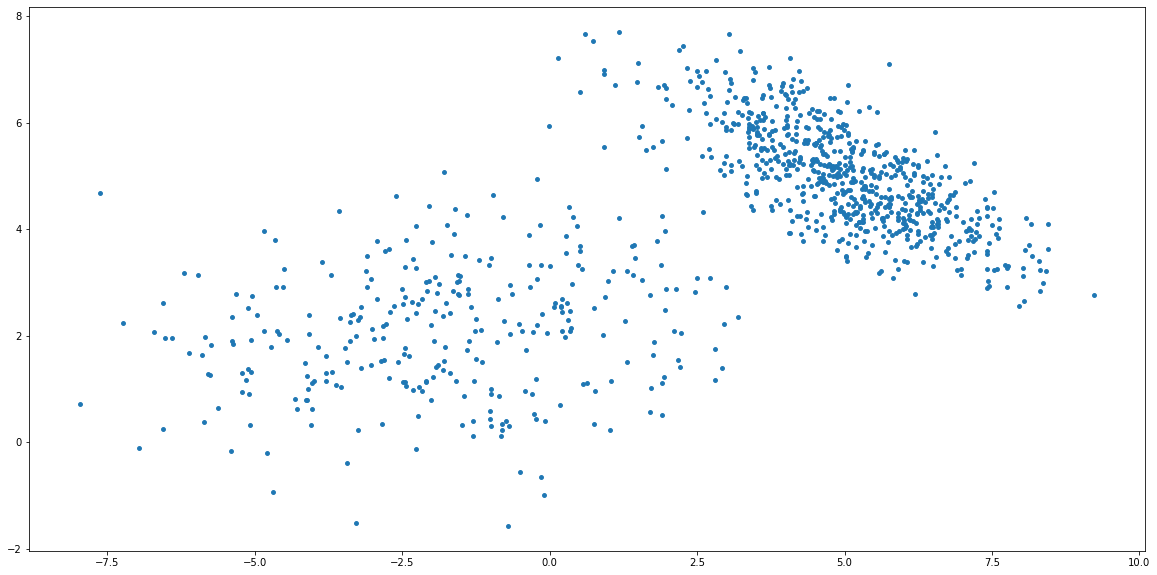

In [699]:
alpha, mu1, mu2, sigma1, sigma2 = 2/3 , np.array([5,5]), np.array([-2,2]), np.array([[2,-1],[-1,1]]) ,np.array([[5,0.5],[0.5,1.5]])

# просемплируем точки из них:
points = 1000

# булевы значения с вероятностью alpha (примерно 2/3 True) 
first_Gaussian = np.array(np.random.rand(points) < alpha)
# матрица 1000х2 так как у нас точка на плоскости потому двумерная
data = np.zeros(shape = (points, 2))
data[first_Gaussian,:] = np.random.multivariate_normal(mu1, sigma1, sum(first_Gaussian))
data[np.invert(first_Gaussian),:] = np.random.multivariate_normal(mu2, sigma2, sum(np.invert(first_Gaussian)))

fig = plt.figure(figsize = (20,10))
ax = fig.subplots()
ax.scatter(data[:,0],data[:,1],s=15)

In [700]:
def gausian_mix_logpdf(x, alpha ,mu1 ,mu2 ,sigma1 ,sigma2):
    return np.log(alpha * sp.stats.multivariate_normal.pdf(x, mean = mu1, cov = sigma1) + (1-alpha) * sp.stats.multivariate_normal.pdf(x, mean = mu2,cov = sigma2))

In [713]:
pallete = sns.color_palette()
def get_last_accepted(samples,is_accepted):
    last_accepted, last_bool = [] , 0
    for i in range(len(samples)-1):
        last_accepted.append(last_bool)
        if is_accepted[i] == 1:
                last_bool = i
    return last_accepted

def plot_random_walk(samples, last_accepted, xlim, ylim, star_points=None):
    fig = plt.figure(figsize=(20,10))
    ax = fig.subplots()
    trace = LineCollection(np.array([ [samples[last_accepted[i-1]], samples[i]] for i in range(1,len(samples)) ]),
                           colors = np.array([pallete[0] if x==1 else 'red' for x in is_accepted[1:]]),zorder=10)
    ax.add_collection(trace)
    ax.autoscale_view()

    if star_points is not None:
        ax.scatter([x[0] for x in star_points],[x[1] for x in star_points], marker = "*", s =300, color ='g',zorder=2)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(data[:,0],data[:,1],s=15,color='orange',alpha = 0.15)
    plt.show()

In [736]:
samples, is_accepted = sampler(lambda x: gausian_mix_logpdf(x, alpha ,mu1 ,mu2 ,sigma1 ,sigma2), 10000 ,q_sigma = 1)
last_accepted = get_last_accepted(samples, is_accepted)

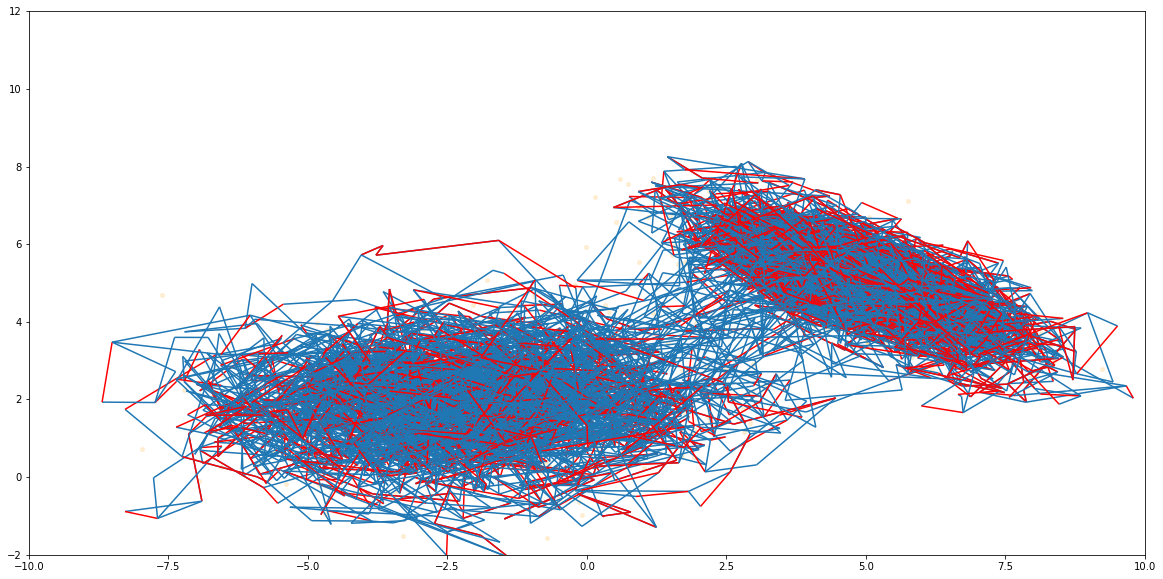

In [737]:
plot_random_walk(samples ,last_accepted , (-10,10), (-2,12), star_points = [mu1,mu2])

### Часть IV. Обучим апостериорное распределение на параметры Гаусиана (на среднее Гаусиана) ###

Возьмём [ простую задачу](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM), чтобы разобраться:

Пусть у нас есть группа из $ n = 16 $ человек, мы знаем, что средняя оценка группы за экзамен $ \mu = 4.1 $ со стандартным отклонением в $ \sigma = 0.5 $. <br><br>
Затем снова учёба,группа ещё сдаёт экзамены, считаем ещё раз получаем, что общее среднее $\mu = 4.7 $, то есть средние значение менялось со временем, давая нам стандартное отклонение среднего класса $\tau$ = 0.6 <br><br>
Теперь мы хотим, обновить наши знания о $\mu$ - среднем значении теста - то есть мы хотим найти $p(μ|X)$ , где $X$ - новые результаты экзамена (т.е. хотим вывести апостериорную вероятность для $\mu$)

Построим гистограмму плотности распределения:

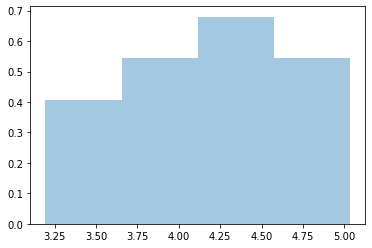

In [402]:
snsplot = sns.distplot(data, kde=False, norm_hist=True)
fig = snsplot.get_figure()

In [401]:
aprior_mean = 4.1
aprior_sigma = 0.5
mean_sigma = 0.6
data = np.random.normal( 4.1 , 0.5 ,16) 

In [387]:
def likelihood_log_function_aposterior(mu ,sigma):
    return np.sum(norm.logpdf(data, loc = mu ,scale = sigma))

In [388]:
setup = sampler(lambda x: likelihood_log_function_aposterior(x, aprior_sigma) , data , aprior_mean = 4.1 , aprior_sigma = 0.5 , samples=1000, burn_in = 5000 , mu_init = 0, q_sigma = 0.2)
setup["acceptance percentage"]

57.3

In [389]:
def plot_proposal(mu_current, mu_proposal, data, accepted, trace, i, aprior_mean , aprior_sigma):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('sample %i' %(i + 1))
    x = np.linspace( 3 , 5 , 5000)
    color = 'g' if accepted else 'r'
        
    prior_current = norm(aprior_mean , aprior_sigma).pdf(mu_current)
    prior_proposal = norm(aprior_mean , aprior_sigma).pdf(mu_proposal)
    prior = norm(aprior_mean , aprior_sigma).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.set(ylabel='Probability Density', title='current: aprior(x=%.2f) = %.2f\nproposal: aprior(x=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    

    likelihood_current = norm(mu_current,  mu_proposal).pdf(data).prod()
    likelihood_proposal = norm(mu_current, mu_proposal).pdf(data).prod()
    y = norm(mu_proposal,  aprior_sigma).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='x_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='x_proposal')
    ax2.set(title='likelihood(x=%.2f) = %.2f\nlikelihood(x=%.2f) = %.2f' % (mu_current, likelihood_current, mu_proposal, likelihood_proposal))
    
    posterior_analytical = estimate_by_conjugate_apriori_distribution(data, x,  aprior_mean, aprior_sigma)
    ax3.plot(x, posterior_analytical)
    posterior_current = estimate_by_conjugate_apriori_distribution(data, mu_current,  aprior_mean, aprior_sigma)
    posterior_proposal = estimate_by_conjugate_apriori_distribution(data, mu_proposal, aprior_mean, aprior_sigma)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.set(title='posterior(x=%.2f) = %.5f\nposterior(x=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
        
    ax4.plot(trace)
    ax4.set(xlabel='sample', ylabel='x', title='trace')    
    plt.tight_layout()

Для каждого искомого параметра нужно выбрать априорное распределение вероятностей.
Для простоты, допустим, что нормальное распределение будет априорным распределением для $\mu$. Применяем [формулки](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%BF%D1%80%D1%8F%D0%B6%D1%91%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B0%D0%BF%D1%80%D0%B8%D0%BE%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5), a тут они же [подробнее ](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM)

In [390]:
def estimate_by_conjugate_apriori_distribution(data, x, mean , sigma):
    tau = 0.6
    n = len(data)
    mu_post = (mean/sigma**2 + data.sum()/tau**2)/(1/sigma**2 + n/tau**2)
    variance_post = (1/sigma**2 + n/tau**2)**(-1)
    return norm(mu_post, np.sqrt(variance_post)).pdf(x)

Здесь - распределение вероятностей для значений $\mu$ после учёта имеющихся данных, принимая во внимание априорную информацию. Но пусть априорное распределение не является сопряжённым и мы не можем решить задачу формулами Баеса. 


**Визуализируем шаги алгоритма:**
* **В первом столбце** - априорное распределение вероятностей, то есть – наши предположения относительно $x_{t}$ до ознакомления с данными.
<br>Распределение не меняется, показываем здесь предложения нового значения $x_{t}$.<br>
Синии линии - текущее положение, зеленые и красные - принятые и отвергнутые предложенные местополодения соответственно.
* **Во втором столбце** – функция правдоподобия и вероятность принятия предложенной точки.
<br>График меняется в соответствии с предлагаемым $x_{t}$.
<br>Cиняя гистограмма – сами данные.
<br>Cплошная линия выводится либо зелёным, либо красным цветом – это график функции правдоподобия при $x_{t}$, предложенном на текущем шаге. 
<br>Чем сильнее функция правдоподобия соответствует гистограмме данных – тем лучше модель объясняет данные и тем выше будет результирующая вероятность
<br>Пунктирная линия зеленого цвета – это предложенный $x_{t}$, пунктирная синяя линия – это текущий $x_{t}$.
* **В третьей колонке** – апостериорное распределение вероятностей
* **В четвёртой колонке** - след выборки,то есть – значения $x_{t}$, сэмплы, полученные на основе модели. Если точка не принята - нет изменений на графике

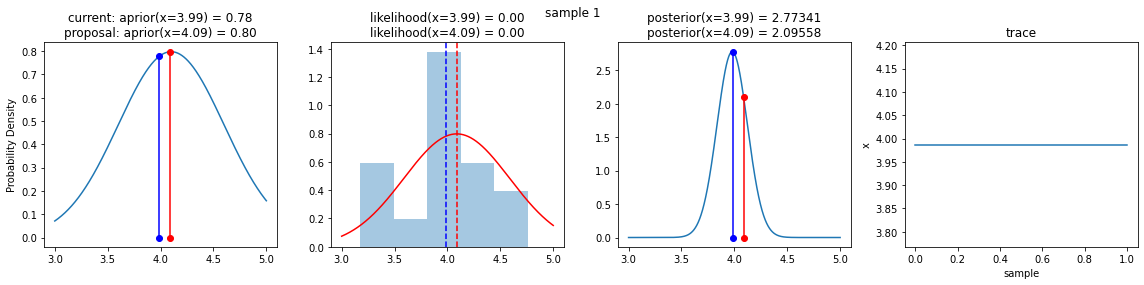

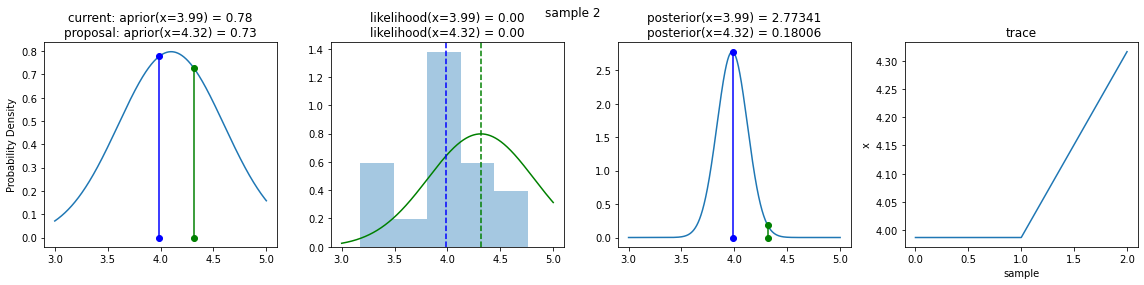

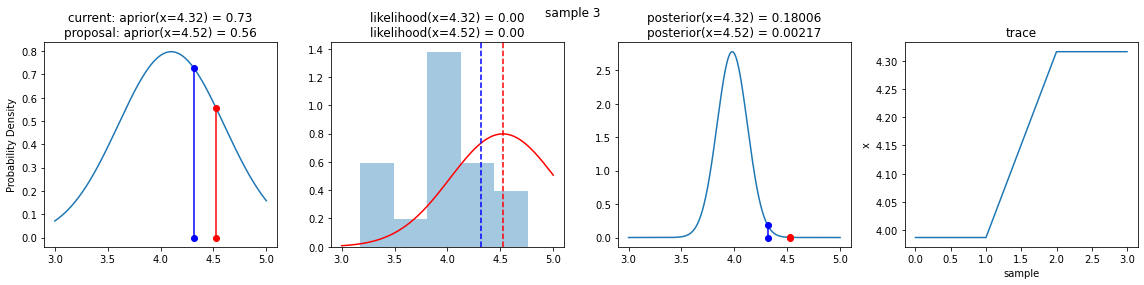

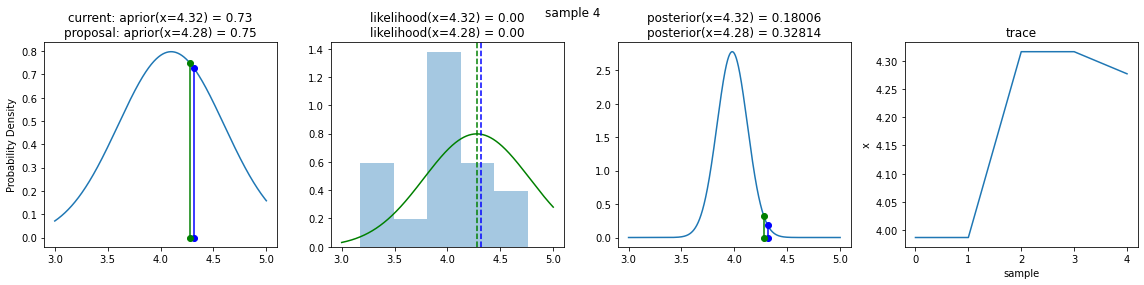

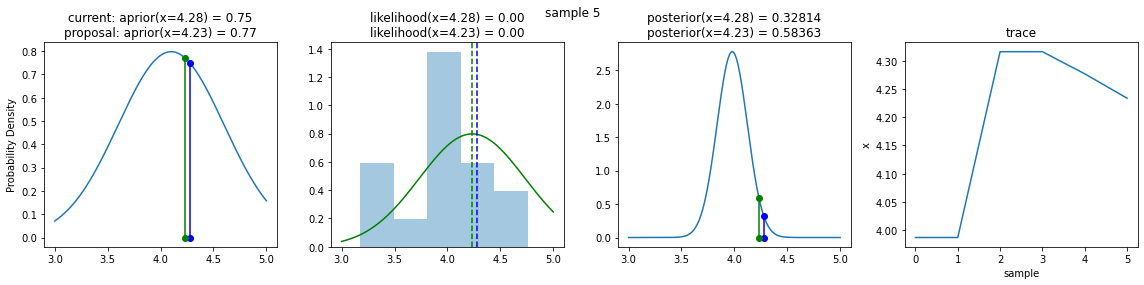

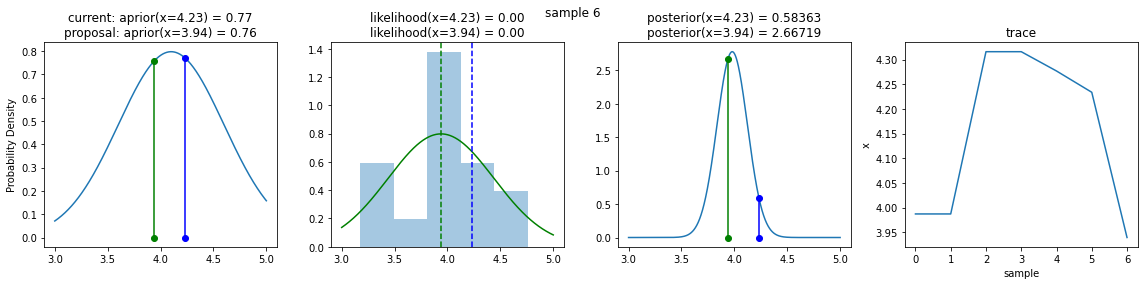

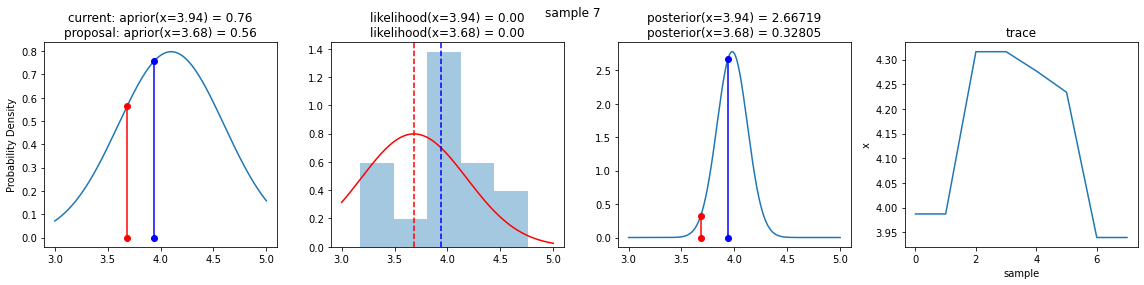

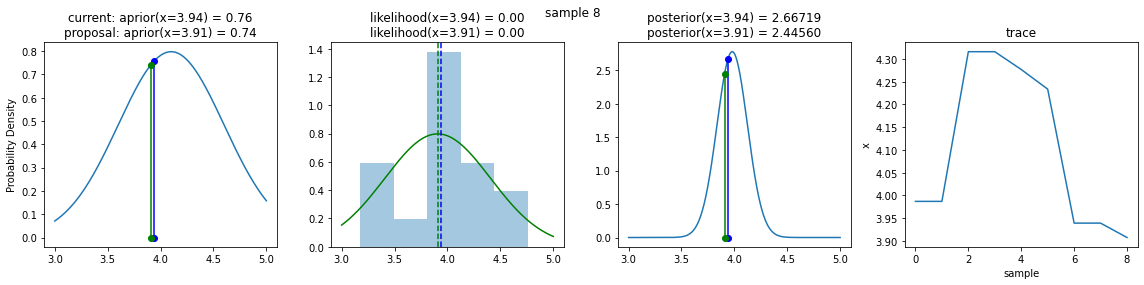

In [397]:
sampler(lambda x: likelihood_log_function_aposterior(x, mean_sigma), data ,aprior_mean, aprior_sigma, samples= 8 , burn_in = 500, q_sigma = 0.2 , mu_init = 0 , plot=True)

**И что? Как это поможет нам найти собственно то, что надо, апостериарную вероятность?**<br>
Посмотрим на след выборки- данные,которые производит система,сгенерируем большое количество сэмплов и глянем на них:

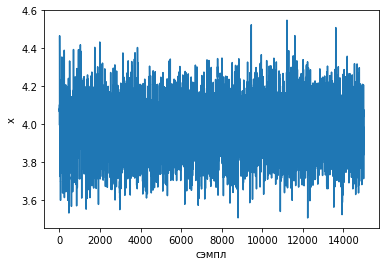

In [392]:
posterior = sampler(lambda x: likelihood_log_function_aposterior(x, aprior_sigma) , data ,aprior_mean = 4.1 , aprior_sigma = 0.5 , samples = 15000 ,burn_in = 1000, q_sigma = 0.2 , mu_init = 0)
fig, ax = plt.subplots()
ax.plot(posterior["posterior"])
_ = ax.set(xlabel='сэмпл', ylabel='x');

In [393]:
np.mean(posterior['acceptance percentage'])

60.553333333333335

Чтобы получить приближённое значение апостериорного распределения вероятностей, достаточно построить гистограмму этих данных.<br><br>
Слёдующий график показывает, каким должно быть $\mu$:<br>

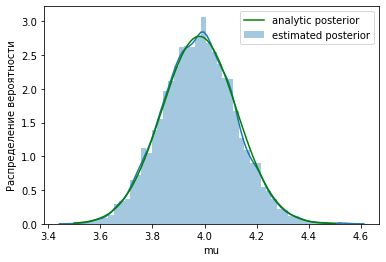

In [395]:
ax = plt.subplot()
sns.distplot(posterior["posterior"], ax=ax, label='estimated posterior')
x = np.linspace(3.5, 4.5, 5000)
post = estimate_by_conjugate_apriori_distribution(data, x , 4.1 , 0.5)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='Распределение вероятности');
ax.legend();

### Часть IV. Особенности Алгоритма Метрополиса-Гастингса ###

* Необходимо делать **burn in** перед применением, на случай, если начальное положение выбрано не удачно - n-ое (обычно 1000) кол-во сэмплов, которые не будут учитываться 
* По-хорошему, берут каждый **n**-ый сэмпл, где **n** подбирается эмпирическим путем, исходя из реально получающейся автокорреляции в последовательности сэмплов (поскольку нам нужны независимые сэмплы, а если брать каждый, то следующая точка блуждания заведомо лежит рядом с предыдущей)
* Метрополис-Гастингс меньше всего подвержен проклятию размерностей, чем другие алгоритмы MCMC

## Самое время попоробовать алгоритм Метрополиса-Гастингса на практике: ##

### Часть I. На что способен сам алгоритм ###

In [ ]:
def is_rus(char):
    return 1072 <= ord(char) <= 1103 or char == ' ' or ord(char) == 1105

def clean_text(s):
    cleared_s = ''.join(ch if ch != '\n' else ' ' for ch in s.lower() if is_rus(ch) or ch == ' ' or ch == '\n')
    return re.sub(' +', ' ', cleared_s)
    
def encrypt_text(text, symbol_pool = list('⨒⨓⨔⨕⨖⊣⊢⊥⊤ℕℤℚℝℂ∅⊂⊃⊄⊅⊩⊮⊫⊯⊪⊨⊭∀∃∄⊲⊳⊴⊵⋪⋫⋬⋭≍≭≣≺≻≼≽≾≿∈∋∉∌⊞⊟⊠⊡')):
    text_chars = sorted(list(set(text)))
    new_chars = np.random.choice(symbol_pool, len(text_chars), replace=False)
    replace_map = dict(zip(text_chars, new_chars))
    return ''.join(replace_map[ch] for ch in text)

def get_message(name, length=None):
    text = open('test_messages/' + name + '.txt', 'r', encoding='utf8').read()
    initial = clean_text(text).strip()[:length]
    encrypted = encrypt_text(initial)
    return initial, encrypted
    
def train_model(corpus):
    cnt_1 = Counter()
    cnt_2 = Counter()
    with open(corpus, 'r', encoding='utf8') as file:
        for line in file:
            line = clean_text(line)
            if line:
                for i in range(len(line) - 1):
                    if is_rus(line[i]):
                        cnt_1[line[i]] += 1
                        if is_rus(line[i + 1]):
                            cnt_2[line[i:i + 2]] += 1
                if is_rus(line[-1]):
                    cnt_1[line[-1]] += 1
    alphabet = [item[0] for item in cnt_1.most_common()]
    m = {}
    for ch1, ch2 in product(alphabet, repeat=2):
        m[ch1 + ch2] = np.log(cnt_2[ch1 + ch2] + 1)
    return alphabet, m

In [ ]:
alphabet, model = train_model('война_и_мир.txt')

In [ ]:
class MetropolisHastingsDecryptor:
    def __init__(self ,alphabet ,m ,naive=False):
        self.alphabet = alphabet # символы алфивита, упорядоченые по убыванию
        self.m = m  # матрица переходов - словарь на котором тренировались
        self.naive = naive # если True, то будем принимать замены, увеличивающие score - наивный подход к оптимизации т.е. отказ от алгоритма Метрополиса-Гастингса,чтобы посмотреть, что выйдет
        self.symbols = []
        self.text = ''
        self.log_score = 0
        self.best_score = 0
        self.map = {} # сивол -> буква/пробел 
        self.best_map = {}
        self.accept_history = [] # принимали замену или нет, Булев массив
        self.score_history = [] # какие были пути
        
    # правдоподобие считаем:
    def get_score(self ,cur_map):
        m_values = np.zeros(len(self.text)-1,dtype = np.float64)
        for i in range(len(self.text) - 1):
            pair = ''.join(cur_map[ch] for ch in self.text[i:i+2])
            m_values[i] = self.m[pair]
        return m_values.sum()
    
    def start_from_text_part(self ,s ,stat=True):
        sym = set(s)
        if not s or len(sym) > len(self.alphabet):
            return False # либо слишком много символов, либо пустой текст
        self.text = s
        self.symbols = sorted(list(sym))
        
        # отвечает за начальное соответствие символам букв, если 1 сотируем по возрастанию
        # чтобы более частым символам соответствовали более частые буквы
        # если нет, то в лексикографическом порядке будет соответствие поставлено
        if stat:
            self.symbols.sort(key = Counter(s).get ,reverse = True)
            
        self.map = dict(zip(self.symbols ,self.alphabet))
        self.log_score = self.get_score(self.map)
        self.best_map = self.map.copy()
        self.best_score - self.log_score
        self.accept_history = []
        self.score_history = []
        return True
    
    def MetropolisHastingsStep(self):
        sym1 , sym2 = np.random.choice(self.symbols , 2, replace = False)   # случайно берем два символа
        new_map = self.map.copy()   # Создаём новую карту, где свапаем их
        new_map[sym1],new_map[sym2] = new_map[sym2], new_map[sym1]
        
        old_score = self.log_score
        new_score = self.get_score(new_map)
        
        MH_cond = np.log(np.random.rand()) < (new_score - old_score)
        
        if new_score > old_score or (not self.naive and MH_cond):
            self.map = new_map
            self.log_score = new_score
            if self.log_score > self.best_score:
                self.best_score = self.log_score
                self.best_map = self.map
                self.accept_history.append(True)
            else:
                self.accept_history.append(False)
            self.score_history.append(self.log_score)
            
    def run(self ,steps ,logging ,print_every=100 ,length=100 ,early_stop=1000):
        if logging:
            print('Входной текст :'+ self.decrypt(self.map,length))
        not_improving = 0
        for step_num in range(steps):
            old_best = self.best_score
            self.MetropolisHastingsStep()
            not_improving += 0 if self.best_score > old_best else 1
            if not_improving == early_stop:
                break
            if logging and (step_num+1)%print_every == 0 :
                print(f'Итерация {step_num + 1:5d}:' + self.decrypt(self.map,length))
        if logging:
            print('Лучшее совпадение: '+ self.decrypt(self.best_map,length))
    
    def decrypt(self ,cur_map ,length=None):
        return ''.join(cur_map[ch] for ch in self.text[:length])
    
    def acc_rate(self):
        acc = np.array(self.accept_history,dtype=bool)
        return f'{100 * acc.sum()/len(acc):.2f}%'
    
    def final(self):
        return self.decrypt(self.best_map)
    
    def get_map(self):
        for symbol, letter in self.best_map.items():
            print(letter,'->',symbol)
    
    def plot(self):
        ax=plt.gca()
        plt.plot(self.score_history)
        ax.set_ylabel('Score')
        ax.set_xlabel('Iteration')
        plt.show()

In [ ]:
initial, encrypted = get_message('поттер', 3000)

In [ ]:
decryptor = MetropolisHastingsDecryptor(alphabet, model)
decryptor.naive = False


decryptor.start_from_text_part(encrypted ,stat=True)

print('Строка:\n' ,initial[:150])
print('\nЗакодированная строка:\n' ,encrypted[:150])
print('\nРаскодированная строка начальным сопостовлением:\n' , decryptor.final()[:150])
print('\nНачальным сопоставление:\n')
decryptor.get_map()

In [ ]:
decryptor.run(40000, logging=True, print_every=1000, length=80, early_stop=None)

In [ ]:
decryptor.final()

In [ ]:
decryptor.acc_rate()

In [ ]:
decryptor.plot()

### Часть II. Метрополис-Гастингс как оптимизатор LDA ###